<a href="https://colab.research.google.com/github/easyhardhoon/autonomous_vision/blob/main/ML_CNN%26YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pytorch를 이용한 3차원 데이터 학습 예제

여기서는 torchvision이 기본 제공하는 CIFAR10 데이터를 활용하였다(CNN의 일종인 LeNet-5 모델 이용함)

추후에 개인 데이터를 활용하는 데이터 학습 코드 구현 예정(Pytorch4 참고하기)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt

#1. 데이터 전처리

**전처리의 순서**

▶transform = transforms.Compose([transforms.ToTensor(),transforms.Resize(16))

---> 기초 전처리 몰아서 해주기

▶trainset = torchvision.datasets.CIFAR10(root='./data',train,download,transform=transform)

---> CIFAR10 데이터 셋 가지고 오기. 기초 전처리는 transform에서 해주도록 하기

▶trainloader = DataLoader(trainset,batch_size,shuffle,num_workers)

---> trainset을 batch_size, shuffle, num_workers등 최종 전처리를 해준 trainloader 리턴/



In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Tensor 타입으로 정규화

#학습용 데이터 셋. 
#torchvision이 제공하는 데이터 셋 CIFAR10 데이터 가져오기.
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

#numworkers : 사용할 서브 프로세스의 수 (보통은 코어의 절반으로 세팅)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

#테스트용 데이터 셋 
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

#클래스들
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


#2. 데이터 확인

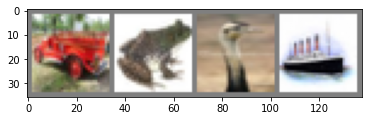

truck  frog  bird  ship


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#이미지 확인하기

def imshow(img):
    img = img / 2 + 0.5     # 정규화 해제
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지 뽑기. 하나하나 읽어올 수 있다. 
dataiter = iter(trainloader)
images, labels = dataiter.next() 

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

# 이미지별 라벨 (클래스) 보여주기
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


#3. 학습 모델 생성하기

**3-1. CNN 정의하기(LeNet-5)**

✅모델을 Class로 정의하는 방법


In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        #input = 3, output = 6, kernal = 5
        self.conv1 = nn.Conv2d(3, 6, 5) #합성곱 계층
        #kernal = 2, stride = 2, padding = 0 (default)
        self.pool = nn.MaxPool2d(2, 2) # 풀링(MAX) 계층
        self.conv2 = nn.Conv2d(6, 16, 5)
        #input feature, output feature
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 완전연결계층 (flatten + 활성화1(relu) + 활성화2(softmax))
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    # 값 계산
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x)) #fc1 이런거는 단순히 행렬곱 연산에 해당된다.
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

✅모델을 Sequential로 정의하는 방법

사실 위의 class 기반 코드와 완전히 동일하다

In [ ]:
model = nn.Sequential(
    nn.Conv2d(3,6,5),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(6, 16, 5),
    nn.Linear(16 * 5 * 5, 120),
    nn.Linear(120, 84),
    nn.Linear(84, 10),
)
"""
model = nn.Sequential(
    nn.Linear(32,384),
    nn.LeakyReLU(0.2),
    nn.Linear(3,10),
    nn.LeakyReLU(0.2),
    nn.Linear(10,10),
    nn.LeakyReLU(0.2),    
    nn.Linear(10,10),
    nn.LeakyReLU(0.2),        
    nn.Linear(10,5),
    nn.LeakyReLU(0.2),          
    nn.Linear(5,1),
) """
print(".")

.


**3-2. Loss와 Optimizer 정의하기**

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#4. 학습하기

In [ ]:
for epoch in range(2):  #데이터셋 2번 받기

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 입력 받기 (데이터 [입력, 라벨(정답)]으로 이루어짐)
        inputs, labels = data

        #학습
        optimizer.zero_grad()
        outputs = net(inputs)
        #outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 결과 출력
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000개마다
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

#여기에 학습한 모델 저장
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

[1,  2000] loss: 2.305
[1,  4000] loss: 2.304
[1,  6000] loss: 2.304
[1,  8000] loss: 2.306
[1, 10000] loss: 2.304
[1, 12000] loss: 2.306
[2,  2000] loss: 2.304
[2,  4000] loss: 2.305
[2,  6000] loss: 2.304
[2,  8000] loss: 2.305
[2, 10000] loss: 2.305
[2, 12000] loss: 2.305
Finished Training


#5. 테스트하기

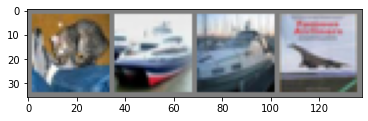

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 실험용 데이터와 결과 출력
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# 학습한 모델로 예측값 뽑아보기
net = Net()
net.load_state_dict(torch.load(PATH))
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

#전체 데이터 셋에 대한 정확도 산출(최종)

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


#CNN의 한계와 발전 방향, 그리고 YOLO


https://www.soyo.or.kr/digital-citizenship/2020/04/24/%ED%95%B4%EC%99%B8-%EA%B8%B0%EC%82%AC%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5%EC%9D%98-%EA%B0%80%EC%9E%A5-%ED%81%B0-%EC%84%B1%EA%B3%BC-%EC%A4%91-%ED%95%98%EB%82%98%EC%9D%B8-cnn%EC%9D%B4-%EB%8C%80/



CNN기반 모델 발전 개요

1. LeNet (CNN 적용)


2. AlexNet (GPU, RELU 함수 적용)

3. ZFNet (하이퍼 파라미터 최적화)

4. VGGNet (작은 필터 수 규칙적 적용)

5. GoogleNet (Inception 모듈 적용)

6. ResNet (SKip connection 적용, 기울기 소실문제해결)

7. DenseNet (진화된 Skip connection 과 bottleneck layers 적용)

---

#윈도우를 활용한 객체 탐지 알고리즘

▶이단계 방식
  
    영역 제안 + 객체 탐지 . 정확하지만 느리다

    ex)Faster R-CNN

▶단일 단계 방식

    정해진 위치와 정해진 크기의 객체만 찾기. 정확도가 떨어지지만 빠르다

    ex) YOLO

    주로 실시간 탐지를 요구하는 어플리케이션에 활용된다


https://rubber-tree.tistory.com/119

  
---

#YOLO  (You Only Look Once)

이미지 내에 존재하는 객체와 해당 객체의 위치는 이미지를 한 번만 보고 예측할 수 있다.

https://curt-park.github.io/2017-03-26/yolo/

#딥러닝의 기본기

컴퓨터도 사람이 생각하는 구조처럼 만들고 싶다

**CNN**을 통해 인공신경망은 이미지를 사람처럼 볼 수 있게 됐다. 결국은 컴퓨터의 최대 장점인 수치연산을 이용한 구조이다

CNN에서 필터(커널)과의 연산으로부터 적절한 수치의 집합을 도출해내고 역전파를 통해 계속 학습한다. 


---

**객체 감지(Object Detection)**란 이미지 안의 객체를 단순히 구분하는 것에서 그치지 않고 이미지 내의 해당 객체의 위치까지 표시하는 알고리즘




여기서 더 발전하여 객체에 대한 **인스턴스 분할(Instance Segmentation)**까지 하여 해당 객체만을  **Mask**
로 표시하여 나타낼 수도 있다


---

오늘날 객체 감지 알고리즘에 활용되는 인공지능 모델들은 해당 작업을 수행하기 위해 2가지 과정을 거친다

사진에서 객체의 위치를 추정하는 **지역화**

해당 위치에 있는 객체가 무엇인지 확인하는 **분류**

이 지역화와 분류를 동시에 하는지 순서대로 2번에 나누어서 하는지에 따라

One-stage 모델과 Two-stage 모델로 나뉜다.

One-stage 모델의 대표가 YOLO이다. 속도가 빠른 대신 정확도가 다소 떨어질 수 있다.


객체의 위치와 속성을 동시에 찾는다.

https://eair.tistory.com/41?category=0



YOLO는 객체 탐지를 실시간으로 해낼 수 있다

가장 연산 시간이 많이 걸리는 CNN을 단 한번만 사용한다.

**Ground-truth** : 데이터의 label 값과 같은 느낌. 학습하고자 하는 데이터의 원본 값

**IOU** : (비젼에서) 딥러닝 모델의 성능 평가 지표. 얼마나 겹치냐

CNN 기법으로  'GoogLeNet'을 한번만 사용하였다. (이미지 분류 용도)

최종 그리드셀은 7*7 기반의 Tensor이며 길이 30의 벡터로 이루어짐. 

5,5,20으로 분할 가능하고 5,5에서 Bounding Box의 중앙 x,y값, 높이와 너비, 해당 객체에 대한 신뢰도 c로 구성된다.

즉, 각 그리드셀 하나당 2개의 Bounding Box를 예측하고 있다. 

나머지 20에서는 학습된 20개의 객체 클래스 중 해당 객체일 확률을 나타낸다. 

각 그리드셀이 각각 2개씩 Bounding Box를 찾다 보니 하나의 객체에 대해 과도한 양의 Bounging Box가 감지되는 경우가 발생한다.

YOLO에서는 이 문제점을 해결하기 위해 Non-max suppresion을 사용한다. 겹치는 내용 모두 제거 & 확률 가장 높은 Box만 남겨두기

YOLO의 LOSS

    1. 인공신경망이 예측한 Bounding Box가 Ground Truth와 얼마나 일치하는가에 대한 오차
    (Localization Loss)

    2. Bounding Box에 객체가 있는지에 대한 여부
    (Confidence Loss)
    
    3. Bounding Box에 상관없이 해당 셀에서 객체 클래스의 신뢰도 계산
    (Class Loss)

이 3가지로 이루어진 LOSS를 통해 신경망이 학습을 하여 객체를 찾아내게 된다.

이렇게 네트워크를 학습시킨 뒤, 예측을 하면 각 셀마다 여러장(2장)의 바운딩 박스가 생기게 된다. 

그 중 물체의 중심을 중심으로 그려진 바운딩 박스는 Confidence Score가 높게 나오고(if문의 높은 페널티 때문) 물체의 중심으로부터 먼 셀이 만드는 바운딩 박스는 Score가 작게 나오게 된다.

최종적으로 여러개의 바운딩 박스를 합치고 수정하게 되면 이미지의 객체 탐지가 완료된다. 

https://medium.com/curg/you-only-look-once-%EB%8B%A4-%EB%8B%A8%EC%A7%80-%ED%95%9C-%EB%B2%88%EB%A7%8C-%EB%B3%B4%EC%95%98%EC%9D%84-%EB%BF%90%EC%9D%B4%EB%9D%BC%EA%B5%AC-bddc8e6238e2










#YOLO 구현


https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=sonyi&logNo=221671064474

xycar에 darknet 라이브러리로 YOLO(v3) 구현 완료.

#최종 결론

1. YOLO는 객체 인식을 해주는 딥러닝 모델이라, xycar 본선에서는 크게 쓸 이유가 없을 것 같다. 장애물 인식 정도는 할 수 있을 것 같긴 하다

2. xycar에 YOLO를 구현하긴 해놨다. 몇 프레임이 나오는지 테스트해보고 만약 장애물을 박스로 인식한다면 어떻게 제어를 해줄 수 있을지만 고민을 해보면 될 것 같다. 

3. YOLO 간략 정리 : 사진 참고

4. http://journal.cg-korea.org/archive/view_article?pid=jkcgs-27-5-63 
